**Seattle AirBNB Data**

CRISP-DM involves the following steps:
* Business Understanding
* Data Understanding
* Data Preparation
* Modeling
* Evaluation
* Deployment

### Business Understanding

Airbnb, Inc is an online marketplace for arranging or offering lodging, primarily homestays, or tourism experiences. The company does not own any of the real estate listings, nor does it host events; it acts as a broker, receiving commissions from each booking. The company is based in San Francisco, California, United States. [https://en.wikipedia.org/wiki/Airbnb]

The main idea for them is to get new clients that provide real estate listings and new clients that need to rent them because in this way they will get more revenue. A relevant fact is to analyze the behavior of the prices, ratings and the use of the service by the clients along the time.

Based on the above I wanna answer this questions:
* How does the price of Seattle Airbnb listing vary throughout the year? Additionally, when are the highest and lowest prices?
* What are the most important factors influencing the ratings of an Airbnb listing?
* What are the most important factors influencing the price of an Airbnb listing?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn import metrics
pd.set_option('display.float_format', lambda x: '%.3f' % x)

c:\users\user\anaconda3\envs\clasificador\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
calendar = pd.read_csv("calendar.csv")
listings = pd.read_csv("listings.csv")
reviews = pd.read_csv("reviews.csv")

**Analysis of Calendar Dataset**

In [3]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
calendar.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [5]:
calendar.shape

(1393570, 4)

In [6]:
# number of missing values
calendar.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [7]:
# % of missing values
calendar.isnull().sum() / calendar.shape[0] * 100

listing_id    0.000
date          0.000
available     0.000
price        32.939
dtype: float64

In the calendar dataset we got almost 33% of missing values in the price column, the main idea here is to check in what months they are.

In [8]:
calendar_null = calendar.copy()
calendar_null["is_null_price"] = calendar.price.isnull()

In [9]:
calendar_null.is_null_price.sum()

459028

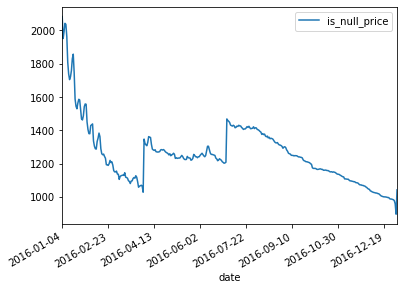

In [10]:
g = calendar_null[["date", "is_null_price"]].groupby("date").sum().plot();
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right');

Clearly, we can observe that the null values in price along the listing dataset are going down in the first 4 months of 2016, after this value went up during 3 months and then final 5 months the decrease in null values was constant.

In [11]:
calendar_null[["available", "is_null_price"]].groupby("available").sum()

,is_null_price
available,
f,459028.000
t,0.000


In [12]:
calendar[["available", "price"]].groupby("available").count()

,price
available,
f,0
t,934542


In [13]:
(934542 + 459028) == calendar.shape[0]

True

Nevertheless, all the missing values correspond to the listing sites that are not available, interesting fact! Which has totally sense.

**Analysis of Listing Dataset**

In [14]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.000,f,nan,WASHINGTON,f,moderate,f,f,2,4.070
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.000,f,nan,WASHINGTON,f,strict,t,t,6,1.480
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.000,f,nan,WASHINGTON,f,strict,f,f,2,1.150
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,nan,f,nan,WASHINGTON,f,flexible,f,f,1,nan
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.000,f,nan,WASHINGTON,f,strict,f,f,1,0.890


In [15]:
# % missing values
columns_of_listings_nulls = listings.isnull().sum()

(columns_of_listings_nulls[columns_of_listings_nulls>0] / listings.shape[0] * 100).sort_values(ascending=False)

license                       100.000
square_feet                    97.459
monthly_price                  60.267
security_deposit               51.126
weekly_price                   47.381
notes                          42.064
neighborhood_overview          27.030
cleaning_fee                   26.977
transit                        24.463
host_about                     22.499
host_acceptance_rate           20.246
review_scores_accuracy         17.234
review_scores_checkin          17.234
review_scores_value            17.182
review_scores_location         17.156
review_scores_cleanliness      17.103
review_scores_communication    17.051
review_scores_rating           16.946
reviews_per_month              16.422
first_review                   16.422
last_review                    16.422
space                          14.903
host_response_time             13.698
host_response_rate             13.698
neighbourhood                  10.896
thumbnail_url                   8.381
medium_url  

We can observe in the listings dataset a lot of missing values (over 20%) for the columns:
* license: 100.000000
* square_feet: 97.459403
* monthly_price: 60.267156
* security_deposit: 51.126244
* weekly_price: 47.380828
* notes: 42.063908
* neighborhood_overview: 27.029859
* cleaning_fee: 26.977475
* transit: 24.463070
* host_about: 22.498690
* host_acceptance_rate: 20.246202

In [16]:
listings.shape

(3818, 92)

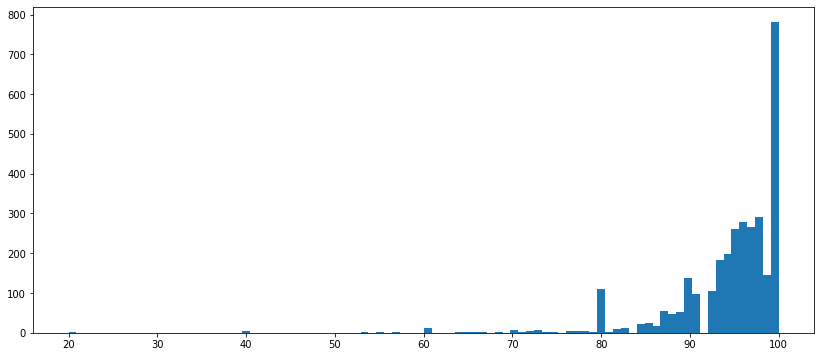

In [17]:
plt.figure(figsize=(14, 6));
plt.hist(listings.review_scores_rating.dropna().values, bins=90);

The review_scores_rating column is crearly left skewed!

In [18]:
np.unique((listings.review_scores_rating.dropna().values%10), return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([1055,  103,  119,  205,  224,  289,  302,  328,  345,  201],
       dtype=int64))

In [19]:
type_ratings, ratings_ocurrences = np.unique(np.round((listings.review_scores_rating.dropna().values/10), 0), return_counts=True)

In [20]:
list(zip(type_ratings, ratings_ocurrences / ratings_ocurrences.sum() * 100))

[(2.0, 0.031535793125197095),
 (4.0, 0.12614317250078838),
 (5.0, 0.031535793125197095),
 (6.0, 0.5045726900031535),
 (7.0, 0.9460737937559129),
 (8.0, 6.3702302112898135),
 (9.0, 28.192999053926204),
 (10.0, 63.796909492273734)]

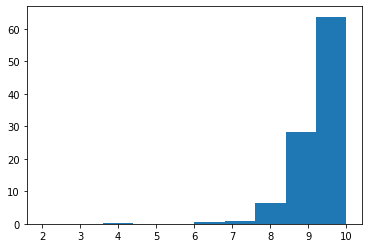

In [21]:
plt.hist(x=type_ratings, weights=ratings_ocurrences / ratings_ocurrences.sum() * 100);

The ratings are concentrated in near values to 9 and 10, almost the 92% of the data!

**Analysis of Reviews Dataset**

In [22]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [23]:
reviews.shape

(84849, 6)

In [24]:
# missing values
reviews.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

In [25]:
reviews.loc[reviews.comments.isnull(), :]

,listing_id,id,date,reviewer_id,reviewer_name,comments
11034,461567,11614247,2014-04-09,12120141,Abbey,NaN
15383,9460,10563024,2014-02-24,12498029,Debra,NaN
15914,2906694,48629316,2015-09-27,44218980,Anush,NaN
16097,910784,9950520,2014-01-21,179481,Enrico,NaN
27280,10695,52378,2010-06-13,105412,Wei,NaN
29467,1018204,10024984,2014-01-26,10571694,Jordan,NaN
30619,6079216,34824019,2015-06-12,31556342,Mack,NaN
31414,3354614,18103248,2014-08-21,12426758,Jeff,NaN
35210,3554558,24863045,2015-01-03,24488791,Eleanor,NaN
37971,1790020,15640556,2014-07-13,16884291,Michael,NaN


***Cleaning Process***

**Calendar**

In [26]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [27]:
calendar.price.dropna()

0          $85.00
1          $85.00
9          $85.00
10         $85.00
14         $85.00
            ...  
1393207    $87.00
1393208    $87.00
1393211    $87.00
1393212    $87.00
1393213    $87.00
Name: price, Length: 934542, dtype: object

In [28]:
def clean_calendar_dataset(df):
    """
    This function converts the date column from object to date type and converts the price from object to float type,
    removing the $ and ',' characters.
    
    Input: raw calendar dataframe
    Output: clean calendar dataframe
    """
    
    df = df.copy()
    # remove the places that are not available
    df = df.loc[df.available=="t",:]
    # transform the date column to date type
    df['date'] = pd.to_datetime(df['date'])
    # transform price to float values without any symbols (e.g. $ and ',' for thousands)
    df["price"] = df.price.str.replace("$", "")
    df["price"] = df.price.str.replace(",", "")
    df["price"] = df["price"].astype(float)
    return df

In [29]:
clean_calendar = clean_calendar_dataset(calendar)

In [30]:
clean_calendar.shape

(934542, 4)

### ***Answer the question 1***:###
How does the price of Seattle Airbnb listing vary throughout the year? Additionally, when are the highest and lowest prices?

In [31]:
agg_date_price = clean_calendar[["date", "price"]].groupby("date").agg(["mean", "std"]).reset_index()

In [32]:
agg_date_price.columns = ["date", "mean_price", "std_price"]

In [33]:
agg_date_price.head()

,date,mean_price,std_price
0,2016-01-04,122.086,87.060
1,2016-01-05,120.681,84.724
2,2016-01-06,120.928,84.615
3,2016-01-07,120.959,83.347
4,2016-01-08,127.641,89.309


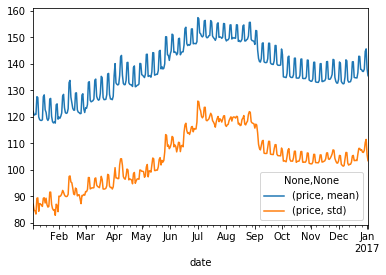

In [34]:
clean_calendar[["date", "price"]].groupby("date").agg(["mean", "std"]).plot();

In the above visualization, we can observe the movement of the prices and the standard deviation of them along the year 2016. The prices are higher in the middle of the year (july, august, september) and the lower prices are at the begin of the year (january and february).

**Listings**

In [35]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.000,f,nan,WASHINGTON,f,moderate,f,f,2,4.070
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.000,f,nan,WASHINGTON,f,strict,t,t,6,1.480
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.000,f,nan,WASHINGTON,f,strict,f,f,2,1.150
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,nan,f,nan,WASHINGTON,f,flexible,f,f,1,nan
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.000,f,nan,WASHINGTON,f,strict,f,f,1,0.890


In [36]:
# important characteristics to use
columns_of_listing_to_use = [
    "host_response_time", "host_response_rate", "host_acceptance_rate", "host_is_superhost",
    "host_listings_count", "host_total_listings_count",
    "neighbourhood_cleansed",
    "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "bed_type",
    "amenities",
    "price", "weekly_price", "monthly_price", "security_deposit", "cleaning_fee", "guests_included", "extra_people", "minimum_nights", "maximum_nights",
    "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location",
    "review_scores_value", "instant_bookable", "cancellation_policy"
]

In [37]:
len(columns_of_listing_to_use)

33

In [38]:
# 30% of the number of columns
len(columns_of_listing_to_use) * 30 / 100

9.9

In [39]:
(listings[columns_of_listing_to_use].isnull().sum(axis=1).sort_values(ascending=False) > 9.9).sum()

447

In [40]:
341/3818*100

8.93137768465165

We will remove the 8.93% of the listings data because these rows contain missing values in more than 30% of the columns.

In [41]:
listings[columns_of_listing_to_use].bathrooms.isnull().sum()

16

In [42]:
listings.bathrooms.dropna().mode()[0], listings.bathrooms.dropna().mean()

(1.0, 1.2594687006838505)

The missing values associated with the column "bathrooms" will be imputed with the value of the mode (1.0) instead of the mean, because it's a most realistic value.

In [43]:
listings[columns_of_listing_to_use].bedrooms.isnull().sum()

6

In [44]:
listings.bedrooms.dropna().mode()[0], listings.bedrooms.dropna().mean()

(1.0, 1.3077124868835257)

The missing values associated with the column "bedrooms" will be imputed with the value of the mode (1.0) instead of the mean, because it's a most realistic value.

In [45]:
def get_weekly_and_monthly_price(row):
    """
    This function change nan values weekly_price and monthly_price columns for each site (require the price column with values)
    
    Input: row without weekly_price or monthly_price
    Output: row with values in weekly_price and monthly_price
    """
    if np.isnan(row["weekly_price"]):
        row["weekly_price"] = row["price"] * 7
    if np.isnan(row["monthly_price"]):
        row["monthly_price"] = row["weekly_price"] * 4
    return row

In [46]:
def clean_money_column(df, column_name, fill_na=None):
    """
    This function change the string representation of a column of money, to float type with fill_na if require
    
    Input: dataframe, column name and value to change if na exists
    Output: df with the column in float type
    """
    df[column_name] = df[column_name].str.replace("$", "")
    df[column_name] = df[column_name].str.replace(",", "")
    df[column_name] = df[column_name].astype(float)
    if fill_na != None:
        df[column_name].fillna(fill_na, inplace=True)
    return df

In [47]:
def clean_listings_dataset(df):
    """
    This function treats the missing values and transformations required for the listings dataset
    
    Input: raw listings dataframe
    Output: clean listings dataframe
    """
    
    df = df.copy()
    # get the subset of the data related to characteristics of the place and the ratings (or similars)
    df = df[columns_of_listing_to_use]
    
    df = df.loc[df.isnull().sum(axis=1) <= 9.9, :]
    
    # remove $ symbols
    df["host_response_rate"] = df.host_response_rate.str.replace("%", "")
    df['host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce')
    df["host_response_rate"].fillna(df["host_response_rate"].mean(), inplace=True)
    
    
    df["host_acceptance_rate"] = df.host_acceptance_rate.str.replace("%", "")
    df['host_acceptance_rate'] = pd.to_numeric(df['host_acceptance_rate'], errors='coerce')
    df["host_acceptance_rate"].fillna(df["host_acceptance_rate"].mean(), inplace=True)
    
    
    df["host_is_superhost"] = df.host_is_superhost.str.replace("f", "0").replace("t", "1").astype(int)
    
    
    df["bathrooms"].fillna(1.0, inplace=True)
    df["bedrooms"].fillna(1.0, inplace=True)
    
    # number of amenities in the site, I know that we can potencially
    df["number_of_amenities"] = df.amenities.str.replace("{", "").str.replace("}", "").str.replace('\"', '').apply(lambda x: len(x.split(",")))
    df.drop("amenities", axis=1, inplace=True)
    
    # transform price to float values without any symbols (e.g. $ and ',' for thousands)
    df = clean_money_column(df, "price")
    df = clean_money_column(df, "weekly_price")
    df = clean_money_column(df, "monthly_price")
    
    df = df.apply(lambda x: get_weekly_and_monthly_price(x), axis=1)

    df = clean_money_column(df, "security_deposit", fill_na=0)
    df = clean_money_column(df, "cleaning_fee")
    df = clean_money_column(df, "extra_people")
    
    
    
    df["review_scores_rating"].fillna(df["review_scores_rating"].mean(), inplace=True)
    
    df["review_scores_accuracy"].fillna(df["review_scores_accuracy"].mean(), inplace=True)
    df["review_scores_cleanliness"].fillna(df["review_scores_cleanliness"].mean(), inplace=True)
    df["review_scores_checkin"].fillna(df["review_scores_checkin"].mean(), inplace=True)
    df["review_scores_communication"].fillna(df["review_scores_communication"].mean(), inplace=True)
    df["review_scores_location"].fillna(df["review_scores_location"].mean(), inplace=True)
    df["review_scores_value"].fillna(df["review_scores_value"].mean(), inplace=True)
    
    df["instant_bookable"] = df.instant_bookable.str.replace("f", "0").replace("t", "1").astype(int)
    
    
    
    df["host_response_time"].fillna("Unknown", inplace=True)
    
    
    df["cleaning_fee"].fillna(df["cleaning_fee"].mean(), inplace=True)
    
    return df
    
    

In [48]:
clean_listings = clean_listings_dataset(listings)

**Now we need to process the categorical values of the clean listings!**

In [49]:
clean_listings.property_type.value_counts().cumsum()/clean_listings.shape[0]*100

House             46.069
Apartment         90.715
Townhouse         93.563
Condominium       95.906
Loft              96.915
Bed & Breakfast   97.716
Cabin             98.339
Other             98.902
Bungalow          99.199
Camper/RV         99.496
Boat              99.644
Tent              99.763
Chalet            99.822
Treehouse         99.881
Dorm              99.941
Yurt              99.970
Name: property_type, dtype: float64

We can clearly observe that the first 5 types of properties correspond to the 97% of the dataset, so we can aggregate the other properties in just the name "Other".

In [50]:
other_type_of_properties = list(set(clean_listings.property_type.value_counts().index) - set(clean_listings.property_type.value_counts()[:5].index))
clean_listings.replace(other_type_of_properties, "Other", inplace=True)
clean_listings.fillna("Other", inplace=True)

In [51]:
# Dummy variables of categorical variables
clean_listings = pd.get_dummies(
    clean_listings,
    columns=["host_response_time", "neighbourhood_cleansed", "property_type", "room_type", "bed_type", "cancellation_policy"])

To answer the question 2 and 3 we need to create and fit a model that can give us the importance of each variable, I will use the random forest because it's a bagging model with will not be overfitting.

### ***Answer the question 2***:###
What are the most important factors influencing the ratings of an Airbnb listing?

In [52]:
clean_listings[['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']].corr()["review_scores_rating"]

review_scores_rating          1.000
review_scores_accuracy        0.620
review_scores_cleanliness     0.642
review_scores_checkin         0.521
review_scores_communication   0.541
review_scores_location        0.368
review_scores_value           0.696
Name: review_scores_rating, dtype: float64

In [53]:
# I will drop all the ratings because all of them are positively correlated to our dependent variable "review_scores_rating"
X = clean_listings.drop(['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value'], axis=1)
Y = clean_listings['review_scores_rating']

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [55]:
rf_clf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_clf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [56]:
importance_of_each_column = pd.DataFrame({'features': X_train.columns, 'importance': rf_clf.feature_importances_})

In [57]:
importance_of_each_column.sort_values('importance', ascending=False)[:10]

,features,importance
19,number_of_amenities,0.076
11,monthly_price,0.057
9,price,0.055
0,host_response_rate,0.054
2,host_is_superhost,0.052
10,weekly_price,0.050
13,cleaning_fee,0.046
15,extra_people,0.041
4,host_total_listings_count,0.037
3,host_listings_count,0.035


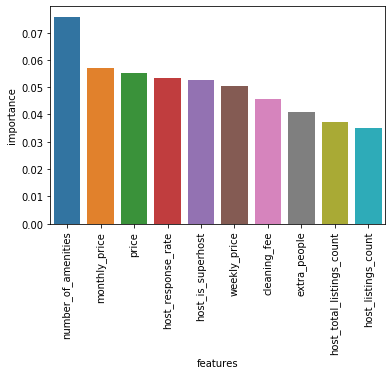

In [58]:
g = sns.barplot(data=importance_of_each_column.sort_values('importance', ascending=False)[:10], x="features", y="importance");
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [59]:
Y_pred = rf_clf.predict(X_test)
np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))

5.639491691409249

Alternatively, I will use linear regression (Ridge, because it penalties huge coefficients) to get the importance of each variable (similar to random forest), and compare the RMSE (root mean square error) of both methods to decide the final result.

In [60]:
lr = Ridge()
lr.fit(X_train, Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [61]:
importance_of_each_column = pd.DataFrame({'features': X_train.columns, 'importance': lr.coef_})

In [62]:
importance_of_each_column.sort_values('importance', ascending=False)[:10]

,features,importance
110,neighbourhood_cleansed_Windermere,3.200
2,host_is_superhost,3.034
111,neighbourhood_cleansed_Yesler Terrace,2.818
27,neighbourhood_cleansed_Arbor Heights,2.471
108,neighbourhood_cleansed_Westlake,2.386
33,neighbourhood_cleansed_Broadview,2.194
48,neighbourhood_cleansed_Genesee,2.192
89,neighbourhood_cleansed_Riverview,1.897
76,neighbourhood_cleansed_North Beach/Blue Ridge,1.845
60,neighbourhood_cleansed_Laurelhurst,1.687


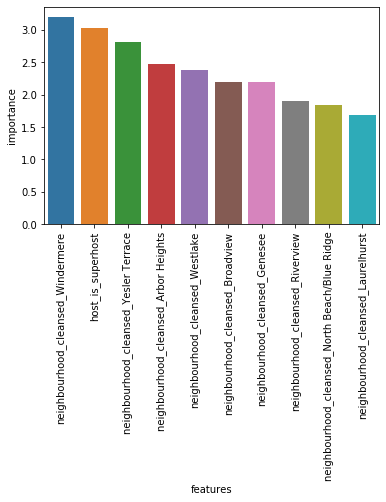

In [63]:
g = sns.barplot(data=importance_of_each_column.sort_values('importance', ascending=False)[:10], x="features", y="importance");
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [64]:
Y_pred = lr.predict(X_test)
np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))

5.6165305560964365

Observing both results we can check that the RMSE_Ridge < RMSE_Random_Forest, nevetheless, the difference is so small. Finally we can check both important variables, by one side its related to the number_of_amenities, prices and host_is_superhost, additionally it's important to consider the neighbourhood of the site.

### ***Answer the question 3***:###
What are the most important factors influencing the price of an Airbnb listing?

In [65]:
X = clean_listings.drop(['price', 'weekly_price', 'monthly_price', 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value'], axis=1)
Y = clean_listings['price']

In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [67]:
rf_clf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_clf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [68]:
importance_of_each_column = pd.DataFrame({'features': X_train.columns, 'importance': rf_clf.feature_importances_})

In [69]:
importance_of_each_column.sort_values('importance', ascending=False)[:10]

,features,importance
7,bedrooms,0.353
6,bathrooms,0.083
115,room_type_Entire home/apt,0.075
5,accommodates,0.069
10,cleaning_fee,0.060
9,security_deposit,0.049
16,number_of_amenities,0.029
12,extra_people,0.026
95,neighbourhood_cleansed_Southeast Magnolia,0.015
14,maximum_nights,0.015


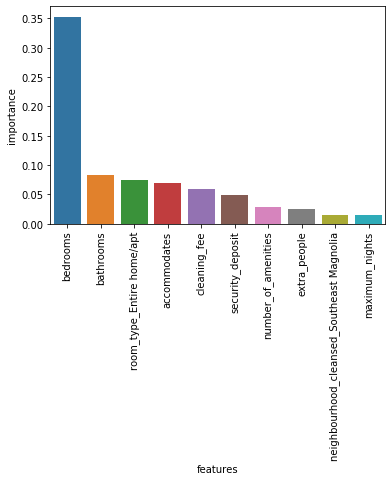

In [70]:
g = sns.barplot(data=importance_of_each_column.sort_values('importance', ascending=False)[:10], x="features", y="importance");
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [71]:
Y_pred = rf_clf.predict(X_test)
np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))

69.77900530416616

In [72]:
lr = Ridge()
lr.fit(X_train, Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [73]:
importance_of_each_column = pd.DataFrame({'features': X_train.columns, 'importance': lr.coef_})
importance_of_each_column.sort_values('importance', ascending=False)[:10]

,features,importance
95,neighbourhood_cleansed_Southeast Magnolia,97.245
82,neighbourhood_cleansed_Pioneer Square,72.439
93,neighbourhood_cleansed_South Lake Union,49.255
80,neighbourhood_cleansed_Pike-Market,47.868
103,neighbourhood_cleansed_West Queen Anne,47.026
105,neighbourhood_cleansed_Westlake,43.209
83,neighbourhood_cleansed_Portage Bay,41.737
70,neighbourhood_cleansed_Montlake,39.432
34,neighbourhood_cleansed_Central Business District,38.170
54,neighbourhood_cleansed_Industrial District,36.617


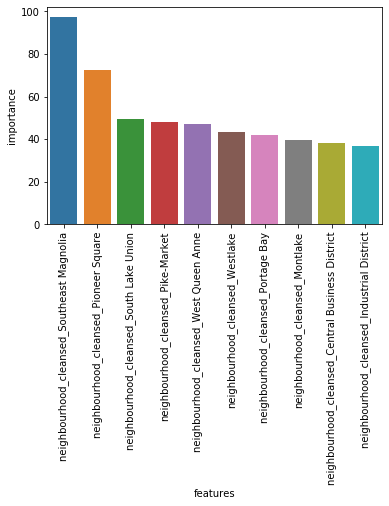

In [75]:
g = sns.barplot(data=importance_of_each_column.sort_values('importance', ascending=False)[:10], x="features", y="importance");
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [74]:
Y_pred = lr.predict(X_test)
np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))

71.00503351667929

The RMSE_Random_Forest < RMSE_Ridge, besides the Ridge coeff are strongly related to the neighbourhood, meanwhile the RF show us that the price of the sites are related with bedrooms, bathrooms, room_type_Entire home/apt, accommodates, cleaning_fee, security_deposit and number_of_amenities.

# Final results

#### 1. How does the price of Seattle Airbnb listing vary throughout the year? Additionally, when are the highest and lowest prices?####
The prices are higher in the middle of the year (july, august, september) and the lower prices are at the begin of the year (january and february).
#### 2. What are the most important factors influencing the ratings of an Airbnb listing?####
The most important factors are: number_of_amenities, prices and host_is_superhost, additionally it's important to consider the neighbourhood of the site.
#### 3. What are the most important factors influencing the price of an Airbnb listing?####
The most important factors are: bedrooms, bathrooms, room_type_Entire home/apt, accommodates, cleaning_fee, security_deposit and number_of_amenities.